# Autograd
这是 Week 6 的 autograd 的一个实现。
## 为什么要自动求导？
当然是因为用起来方便啊
## 总体思路：
 * 定义好计算图（静态图）
 * 根据已经定义的图，进行前传（foward）得到损失（loss）。
 * 根据已经定义的图，进行反向传播（backward），使得梯度（gradient）反向流动。


In [54]:
# imports
import numpy as np
import math
from functools import reduce
import matplotlib.pyplot as plt
from tqdm import notebook
import pickle

## 注册节点和会使用到的信息所使用的变量（dict）

In [55]:
variables = {}

## 辅助函数
```get_by_name```: 按照变量名称获取 ```variables``` 中的变量

In [56]:
def get_by_name(name):
    if 'variables' in globals():
        try:
            return variables[name]
        except:
            raise Exception('Variable with given name: %s is not in variables '%name)
    else:
        raise Exception('"variables" is not defined.')

## Variable 类
用到的所有参与计算的变量

使用 '-' 来分隔每个变量下的属性
### 参数初始化
```initializer```

随机，全零，或者 MSRA 方式的初始化：一个均值为 0 方差为 $\frac{2}{n}$ 的高斯分布。

每个 ```Variable``` 都有对应的 ```child``` 和 ```parent```。

每个 ```Variable``` 都有 ```apply_gradient``` 方法，用于将计算得出的梯度 ```grad``` 应用到对应 ```data``` (weight) 上面

每个 ```Variable``` 都有 ```learnable``` 和 ```grad``` 属性，代表是否是可学习变量和是否需要求导。同时，```waiting_for_backprop``` 代表该变量当前是否需要反向传播。

In [57]:
# Variable.py

class Variable(object):
    initial_method = 'MSRA'
    method = 'SGD'

    def __init__(self, shape=list, name=str, scope='', grad=True, learnable=False, init='MSRA'):
        if scope != '':
            self.scope = scope if scope[-1] == '-' else scope + '-'
            self.name = self.scope + name
        else:
            self.name = name
            self.scope = scope

        if self.name in variables:
            raise Exception('Variable with given name: %s exists!' % self.name)
        else:
            variables[self.name] = self

        for idx, v in enumerate(shape):
            if not isinstance(v, int):
                if isinstance(v, float):
                    shape[idx] = int(v)
                    continue
                raise Exception("Variable name: %s shape is not list of int"%self.name)

        self.shape = shape
        self.data = self.initializer(shape, self.initial_method)
        self.child = []
        self.parent = []

        if grad:
            self.grad = np.zeros(self.shape)
            self.waiting_for_backprop = True
            self.learnable = learnable

    def eval(self):
        for operator in self.parent:
            variables[operator].forward()
        self.waiting_for_backprop = True
        return self.data

    def backward(self):
        if self.waiting_for_backprop:
            for operator in self.child:
                variables[operator].backward()
            self.waiting_for_backprop = False
        else:
            pass

        return self.grad

    def apply_gradient(self, learning_rate=float, decay_rate=float, batch_size=1):
        self.data *= (1 - decay_rate)
        if self.method == 'SGD':
            learning_rate = learning_rate
            self.data -= (learning_rate * self.grad / batch_size)
            self.grad *= 0

        elif self.method == 'Momentum':
            self.mtmp = self.momentum * self.mtmp + self.grad / batch_size
            self.data -= learning_rate * self.mtmp
            self.grad *= 0

        else:
            raise Exception('No apply_gradient method: %s'%self.method)

    def set_method_sgd(self):
        self.method = 'SGD'

    def set_method_momentum(self, momentum=0.9):
        self.method = 'Momentum'
        self.momentum = momentum
        self.mtmp = np.zeros(self.grad.shape)

    # this function initialize an array with given shape and method.
    def initializer(self, shape, method):
        # random initialization
        if method == 'const':
            return np.random.standard_normal(shape) / 100
        
        # initialize with all zero
        if method == 'None':
            return np.zeros(shape)
        # MSRA method
        if method == 'MSRA':
            weights_scale = math.sqrt(reduce(lambda x, y: x * y, shape) / shape[-1])
            return np.random.standard_normal(shape) / weights_scale

## Operator 基类
用于定义变量间的操作。

初始化函数中的 ```input_variable``` 和 ```output_variable``` 用于初始化该 ```Operator``` 对应的边的父节点和子节点。

留出 ```forward()``` 和 ```backward()``` 方法，等待重载。

具有 ```waiting_for_forward``` 属性，代表该节点此时是否正在等待前向传播。

前传时，首先确定父节点（变量）已求值完毕，再对自身求值，最后 unset 自身 ```waiting_for_forward``` 属性。

反向传播时，首先确定该节点是否正在等待前传，若是则跳过；检查子节点（变量）是否正在等待被微分并进行微分，再对自身求值，最后 set 自身 ```waiting_for_forward``` 属性。

In [58]:
class Operator(object):
    def __init__(self, name, input_variables, output_variables):
        
        # init input check
        if name in variables.keys():
            raise Exception("Operator %s exists !"%name)
        
        if not isinstance(input_variables, Variable) and not isinstance(input_variables[0], Variable):
            raise Exception("Operator %s 's input_variables is not instance (or list) of Variable!")

        if not isinstance(output_variables, Variable) and not isinstance(output_variables[0], Variable):
            raise Exception("Operator %s 's output_variables is not instance (or list) of Variable!")

        self.name = name
        variables[self.name] = self
        
        self.child = []
        self.parent =[]
        
        # register for input Variable's child node and output Variable's parents' node
        register_graph(input_variables, output_variables, self)

        self.waiting_for_forward = True

    def forward(self):
        pass

    def backward(self):
        pass

## 卷积层

规定的 ```kernel_shape``` 的格式为 【卷积核边长（假设卷积核形状为正方形），卷积核边长，输入图片通道数量，输出图片通道数量】

In [59]:
class Conv2D(Operator):

    def __init__(self, kernel_shape=list, input_variable=Variable, name=str, stride=1, padding='SAME'):
        # kernel_shape = [ksize, ksize, input_channels, output_channels]
        for i in kernel_shape:
            if not isinstance(i, int):
                raise Exception("Operator Conv2D name: %s kernel shape is not list of int" % self.name)

        if not isinstance(input_variable, Variable):
            raise Exception("Operator Conv2D name: %s's input_variable is not instance of Variable" % name)

        if len(input_variable.shape)!=4:
            raise Exception("Operator Conv2D name: %s's input_variable's shape != 4d Variable!" % name)

        self.ksize = kernel_shape[0]
        self.stride = stride
        self.output_num = kernel_shape[-1]
        self.padding = padding
        self.col_image = []

        self.weights = Variable(kernel_shape, scope=name, name='weights',learnable=True)
        self.bias = Variable([self.output_num], scope=name, name='bias', learnable=True)
        self.batch_size = input_variable.shape[0]

        if self.padding == 'SAME':
            _output_shape = [self.batch_size, input_variable.shape[1] / stride, input_variable.shape[2] / stride,
                             self.output_num]
        if self.padding == 'VALID':
            _output_shape = [self.batch_size, (input_variable.shape[1] - self.ksize + 1) / stride,
                             (input_variable.shape[2] - self.ksize + 1) / stride, self.output_num]

        self.output_variables = Variable(_output_shape, name='out', scope=name)  # .name
        self.input_variables = input_variable
        Operator.__init__(self, name, self.input_variables, self.output_variables)

    def forward(self):
        if self.waiting_for_forward:
            for parent in self.parent:
                variables[parent].eval()
            self._conv(self.input_variables, self.output_variables, self.weights.data, self.bias.data)
            self.waiting_for_forward = False
            return
        else:
            pass

    def backward(self):
        if self.waiting_for_forward:
            pass
        else:
            for child in self.child:
                variables[child].backward()
            self._deconv(self.input_variables, self.output_variables, self.weights, self.bias)
            self.waiting_for_forward = True
            return

    def _deconv(self, input=Variable, output=Variable, weights=Variable, bias=Variable):
        col_eta = np.reshape(output.grad, [self.batch_size, -1, self.output_num])
        for i in range(self.batch_size):
            weights.grad += np.dot(self.col_image[i].T, col_eta[i]).reshape(self.weights.shape)
        bias.grad += np.sum(col_eta, axis=(0, 1))

        # deconv of padded eta with flippd kernel to get next_eta
        if self.padding == 'VALID':
            pad_eta = np.pad(output.grad, (
                (0, 0), (self.ksize - 1, self.ksize - 1), (self.ksize - 1, self.ksize - 1), (0, 0)),
                             'constant', constant_values=0)

        if self.padding == 'SAME':
            pad_eta = np.pad(output.grad, (
                (0, 0), (self.ksize / 2, self.ksize / 2), (self.ksize / 2, self.ksize / 2), (0, 0)),
                             'constant', constant_values=0)

        col_pad_eta = np.array([im2col(pad_eta[i][np.newaxis, :], self.ksize, self.stride) for i in range(self.batch_size)])
        flip_weights = np.flipud(np.fliplr(weights.data))
        flip_weights = flip_weights.swapaxes(2,3)
        col_flip_weights = flip_weights.reshape([-1, weights.shape[2]])
        next_eta = np.dot(col_pad_eta, col_flip_weights)
        next_eta = np.reshape(next_eta, input.shape)
        input.grad = next_eta
        return

    def _conv(self, input=Variable, output=Variable, weights=np.ndarray, bias=np.ndarray):
        # reshape weights to col
        col_weights = weights.reshape(-1, self.output_num)

        # padding input_img according to method
        if self.padding == 'SAME':
            batch_img = np.pad(input.data, (
                (0, 0), (self.ksize / 2, self.ksize / 2), (self.ksize / 2, self.ksize / 2), (0, 0)),
                               'constant', constant_values=0)
        else:
            batch_img = input.data

        # malloc tmp output_data
        conv_out = np.zeros(output.data.shape)

        self.col_image = []
        # do dot for every image in batch by im2col dot col_weight
        for i in range(self.batch_size):
            img_i = batch_img[i][np.newaxis, :]
            col_image_i = im2col(img_i, self.ksize, self.stride)
            conv_out[i] = np.reshape(np.dot(col_image_i, col_weights) + bias, output.data[0].shape)
            self.col_image.append(col_image_i)
        self.col_image = np.array(self.col_image)

        output.data = conv_out
        return

## 卷积层用到的 im2col

In [60]:
def get_im2col_indices(x_shape, filter_height, filter_width, padding=0, stride=1):
    # First figure out what the size of the output should be
    N, C, H, W = x_shape
    assert (H + 2 * padding - filter_height) % stride == 0
    assert (W + 2 * padding - filter_height) % stride == 0
    
    out_height = int((H + 2 * padding - filter_height) / stride + 1)
    out_width = int((W + 2 * padding - filter_width) / stride + 1)

    i0 = np.repeat(np.arange(filter_height), filter_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    
    j0 = np.tile(np.arange(filter_width), filter_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), filter_height * filter_width).reshape(-1, 1)

    return (k, i, j)

def im2col_indices(x, filter_height, filter_width, padding=0, stride=1):
    """ An implementation of im2col based on some fancy indexing """
    # Zero-pad the input
    p = padding
    x_padded = np.pad(x, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant')

    k, i, j = get_im2col_indices(x.shape, filter_height, filter_width, padding,
                                 stride=stride)

    cols = x_padded[:, k, i, j]
    C = x.shape[1]
    cols = cols.transpose(1, 2, 0).reshape(filter_height * filter_width * C, -1)
    return cols

# def im2col(image, ksize, stride):
#     print(image.shape)
#     N, H, W, C = image.shape
#     image_temp = image.reshape(N, H, W, C)
#     im2coled_image = im2col_indices(image_temp, ksize, ksize, padding=0, stride=stride)
#     return im2coled_image.reshape((H - 2) * (W - 2), 25 * C)
def im2col(image, ksize, stride):
    image_col = []
    # print(image.shape)
    for i in range(0, image.shape[1] - ksize + 1, stride):
        for j in range(0, image.shape[2] - ksize + 1, stride):
            col = image[:, i:i + ksize, j:j + ksize, :].reshape([-1])

            image_col.append(col)
    image_col = np.array(image_col)
    # print(image_col.shape)
    return image_col

## 最大池化层
```ksize``` 是卷积核大小。

In [61]:
class MaxPooling(Operator):
    def __init__(self, ksize=2, input_variable=Variable, name=str, stride=2):

        if not isinstance(input_variable, Variable):
            raise Exception("Operator Conv2D name: %s's input_variable is not instance of Variable" % name)


        self.ksize = ksize
        self.stride = stride
        self.batch_size = input_variable.shape[0]
        self.output_channels = input_variable.shape[-1]
        self.index = np.zeros(input_variable.shape)

        self.input_variables = input_variable
        _output_shape = [self.batch_size, input_variable.shape[2] / stride, input_variable.shape[2] / stride,
                         self.output_channels]
        self.output_variables = Variable(_output_shape, name='out', scope=name)
        Operator.__init__(self, name, self.input_variables, self.output_variables)

    def forward(self):
        if self.waiting_for_forward:
            for parent in self.parent:
                variables[parent].eval()
            self._pool()
            self.waiting_for_forward = False
            return
        else:
            pass

    def backward(self):
        if self.waiting_for_forward:
            pass
        else:
            for child in self.child:
                variables[child].backward()
            self.input_variables.grad = np.repeat(np.repeat(self.output_variables.grad, self.stride, axis=1),
                                                  self.stride, axis=2) * self.index
            self.waiting_for_forward = True
            return

    def _pool(self):
        _out = np.zeros(self.output_variables.shape)
        for b in range(self.input_variables.shape[0]):
            for c in range(self.output_channels):
                for i in range(0, self.input_variables.shape[1], self.stride):
                    for j in range(0, self.input_variables.shape[2], self.stride):
                        _out[b, i // self.stride, j // self.stride, c] = np.max(
                            self.input_variables.data[b, i:i + self.ksize, j:j + self.ksize, c])
                        index = np.argmax(self.input_variables.data[b, i:i + self.ksize, j:j + self.ksize, c])
                        self.index[b, i+index // self.stride, j + index % self.stride, c] = 1
        self.output_variables.data = _out
        return

## 全连接层

In [62]:
class FullConnection(Operator):
    def __init__(self, output_num, input_variable=Variable, name=str):
        if not isinstance(input_variable, Variable):
            raise Exception("Operator Conv2D name: %s's input_variable is not instance of Variable" % name)

        self.batch_size = input_variable.shape[0]
        input_len = reduce(lambda x, y: x * y, input_variable.shape[1:])
        self.output_num = output_num
        self.weights = Variable([input_len, self.output_num], name='weights', scope=name, init='const' ,learnable=True)
        self.bias = Variable([self.output_num], name='bias', scope=name, init='const',learnable=True)

        self.output_variables = Variable([self.batch_size, self.output_num], name='out', scope=name)
        self.input_variables = input_variable
        Operator.__init__(self, name, self.input_variables, self.output_variables)

    def forward(self):
        if self.waiting_for_forward:

            for parent in self.parent:
                variables[parent].eval()
            self.flatten_x = self.input_variables.data.reshape([self.batch_size, -1])
            self.output_variables.data = np.dot(self.flatten_x, self.weights.data)+self.bias.data
            self.waiting_for_forward = False
            return
        else:
            pass

    def backward(self):
        if self.waiting_for_forward:
            pass
        else:
            for child in self.child:
                variables[child].backward()

            for i in range(self.batch_size):
                col_x = self.flatten_x[i][:, np.newaxis]
                diff_i = self.output_variables.grad[i][:, np.newaxis].T
                self.weights.grad += np.dot(col_x, diff_i)
                self.bias.grad += diff_i.reshape(self.bias.shape)
            next_grad = np.dot(self.output_variables.grad, self.weights.data.T)
            self.input_variables.grad = np.reshape(next_grad, self.input_variables.shape)

            self.waiting_for_forward = True
            return

## Softmax 输出

In [63]:
class SoftmaxLoss(Operator):
    def __init__(self, predict=Variable, label=Variable, name=str):
        self.batch_size = predict.shape[0]
        self.input_variables = [predict, label]
        self.loss = Variable([1], name='loss', scope=name, init='None')
        self.prediction = Variable(predict.shape, name='prediction', scope=name)
        self.softmax = np.zeros(self.prediction.shape)

        self.output_variables = [self.loss, self.prediction]
        Operator.__init__(self, name, self.input_variables, self.output_variables)

    def forward(self):
        if self.waiting_for_forward:
            for parent in self.parent:
                variables[parent].eval()

            predict = self.input_variables[0].data
            label = self.input_variables[1].data

            self.prediction.data = self.predict(predict)
            self.loss.data = 0
            for i in range(self.batch_size):
                self.loss.data += np.log(np.sum(np.exp(predict[i]))) - predict[i, label[i]]
            self.loss.data /= self.batch_size
            
            self.waiting_for_forward = False
            return
        else:
            pass


    def backward(self):
        if self.waiting_for_forward:
            pass
        else:
            for child in self.child:
                variables[child].backward()
            self.input_variables[0].grad = self.softmax.copy()
            for i in range(self.batch_size):
                self.input_variables[0].grad[i, self.input_variables[1].data[i]] -= 1
            self.waiting_for_forward = True
            return

    def predict(self, prediction):
        exp_prediction = np.zeros(prediction.shape)
        self.softmax = np.zeros(prediction.shape)
        for i in range(self.batch_size):
            prediction[i, :] -= np.max(prediction[i, :])
            exp_prediction[i] = np.exp(prediction[i])
            self.softmax[i] = exp_prediction[i]/np.sum(exp_prediction[i])
        return self.softmax

## 注册图
根据 ```input_variable``` ```output_variable``` 和对应的 ```operator``` 在对应的 ```Variable``` 类实例中注册子节点和父节点

In [64]:
def register_graph(input_variable, output_variable, operator):
    if isinstance(input_variable,Variable) and isinstance(output_variable, Variable):
        input_variable.child.append(operator.name)
        output_variable.parent.append(operator.name)
        operator.parent.append(input_variable.name)
        operator.child.append(output_variable.name)

    elif isinstance(input_variable, Variable) and len(output_variable)>1:
        for output in output_variable:
            input_variable.child.append(operator.name)
            output.parent.append(operator.name)
            operator.parent.append(input_variable.name)
            operator.child.append(output.name)

    elif isinstance(output_variable, Variable) and len(input_variable)>1:
        for _input in input_variable:
            _input.child.append(operator.name)
            output_variable.parent.append(operator.name)
            operator.parent.append(_input.name)
            operator.child.append(output_variable.name)

    elif len(output_variable)> 1 and len(input_variable)> 1:
        for _input in input_variable:
            _input.child.append(operator.name)
            operator.parent.append(_input.name)
        for output in output_variable:
            output.parent.append(operator.name)
            operator.child.append(output.name)

    else:
        raise Exception('Operator name %s input,output list error'% operator.name)

## 激活函数（ReLU）

In [65]:
class Relu(Operator):
    def __init__(self, input_variable=Variable, name=str):
        self.input_variables = input_variable
        self.output_variables = Variable(self.input_variables.shape, name='out', scope=name)
        Operator.__init__(self, name, self.input_variables, self.output_variables)

    def forward(self):
        if self.waiting_for_forward:
            for parent in self.parent:
                variables[parent].eval()
            self.output_variables.data = np.maximum(self.input_variables.data, 0)
            self.waiting_for_forward = False
            return
        else:
            pass

    def backward(self):
        if self.waiting_for_forward:
            pass
        else:
            for child in self.child:
                variables[child].backward()
            self.input_variables.grad = self.output_variables.grad
            self.output_variables.grad[self.input_variables.data < 0] = 0
            self.waiting_for_forward = True
            return

## 读入数据

In [66]:
# load data
data = np.load('mnist.npz')
X, y, X_val, y_val, X_test, y_test = data['X'], data['y'], data['X_val'], data['y_val'], data['X_test'], data['y_test']
# preprocessing
# original: [0, 255]
# after: [0, 1]
X /= 255
X_val /= 255
X_test /= 255
# reshape the image data to NHWC format
X = X.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

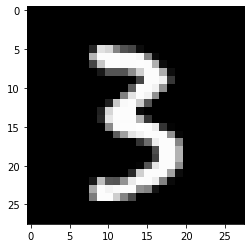

In [67]:
plt.imshow(X[1, :, :, 0], cmap='gray')
plt.show()

## 生成 mini_batch

In [68]:
# mini batches
# feed 125 examples to network at one time
batch_size = 125
# split mini batches
data_length = X.shape[0]
X_mini_batches = [X[i:i + batch_size] for i in range(0, data_length, batch_size)]
y_mini_batches = [y[i:i + batch_size] for i in range(0, data_length, batch_size)]
X_test_mini_batches = [X_test[i:i + batch_size] for i in range(0, len(X_test), batch_size)]
y_test_mini_batches = [y_test[i:i + batch_size] for i in range(0, len(y_test), batch_size)]
X_val_mini_batches = [X_val[i:i + batch_size] for i in range(0, len(X_val), batch_size)]
y_val_mini_batches = [y_val[i:i + batch_size] for i in range(0, len(y_val), batch_size)]

## 定义网络前传操作(图)

In [69]:
def network_forward(input, output_num):
    conv1_out = Conv2D((5, 5, 1, 12), input_variable=input, name='conv1', padding='VALID').output_variables
    relu1_out = Relu(input_variable=conv1_out, name='relu1').output_variables
    #dropout1_out = op.DropOut(input_variable=relu1_out, name='dropout1', phase='train', prob=0.7).output_variables
    pool1_out = MaxPooling(ksize=2, input_variable=relu1_out, name='pool1').output_variables

    conv2_out = Conv2D((3, 3, 12, 24), input_variable=pool1_out, name='conv2').output_variables
    relu2_out = Relu(input_variable=conv2_out, name='relu2').output_variables
    #dropout2_out = op.DropOut(input_variable=relu2_out, name='dropout2', phase='train', prob=0.7).output_variables
    pool2_out = MaxPooling(ksize=2, input_variable=relu1_out, name='pool2').output_variables

    fc_out = FullConnection(output_num=output_num, input_variable=pool2_out, name='fc').output_variables
    return fc_out

## 定义给每次训练 mini_batch 时候用的 data 和 label 槽位

In [70]:
img_placeholder = Variable((batch_size, 28, 28, 1), name='data')
label_placeholder = Variable([batch_size, 1], name='label')

## 定义 Softmax 分类器

将前传用到的 ```img_placeholder``` 槽与输出绑定。

将输出与分类器和正确 label ```label_placeholder``` 槽绑定。

In [71]:
prediction = network_forward(img_placeholder, 10)
sf = SoftmaxLoss(prediction, label_placeholder, 'sf')

## 训练

In [72]:
iterate_count = 3
for i in notebook.tqdm_notebook(range(iterate_count)):
    # iterate through all datasets
    for idx, (X_batch, y_batch) in notebook.tqdm_notebook(enumerate(zip(X_mini_batches, y_mini_batches)), total = len(X_mini_batches)):
        img_placeholder.data = X_batch
        label_placeholder.data = y_batch.astype(np.int)

        # forward
        loss_value = sf.loss.eval()
        pred = sf.prediction.eval()
        acc = np.mean(np.argmax(pred, axis=1) == y_batch)

        acc_str = str(100 * acc) + "%"

        if idx % 25 == 0:
            print("Index " + str(idx) + " in iteration " + str(i) + ": loss: " + str(loss_value) + ", acc: " + acc_str)
            # print(pred)
            # print(y_batch)
            # print(np.argmax(pred, axis=1) == y_batch)
            
        # backward
        dimg = img_placeholder.backward()
        # apply gradient
        for variable_name in variables:
            variable_instance = variables[variable_name]
            if isinstance(variable_instance, Variable) and variable_instance.learnable:
                variable_instance.apply_gradient(learning_rate=8e-2, decay_rate=3e-4, batch_size=batch_size)
            if isinstance(variable_instance, Variable):
                variable_instance.grad = np.zeros(variable_instance.shape)
        # if (acc > 0.8):
        #     print("Now acc > 0.8. Break.")
        #     break

Index 0 in iteration 0: loss: 2.5645669342693265, acc: 7.199999999999999%
Index 25 in iteration 0: loss: 0.8613034931148064, acc: 76.8%
Index 50 in iteration 0: loss: 0.4647399818086439, acc: 85.6%
Index 75 in iteration 0: loss: 0.4397584107314884, acc: 88.8%
Index 100 in iteration 0: loss: 0.38444288033630186, acc: 87.2%
Index 125 in iteration 0: loss: 0.3148070990532096, acc: 92.0%
Index 150 in iteration 0: loss: 0.36907060663999847, acc: 87.2%
Index 175 in iteration 0: loss: 0.18908156432415285, acc: 95.19999999999999%
Index 200 in iteration 0: loss: 0.2651221763224927, acc: 90.4%
Index 225 in iteration 0: loss: 0.1414590804370672, acc: 96.8%
Index 250 in iteration 0: loss: 0.2176724822648768, acc: 93.60000000000001%
Index 275 in iteration 0: loss: 0.1621818828123404, acc: 96.0%
Index 300 in iteration 0: loss: 0.23892980759925025, acc: 92.0%
Index 325 in iteration 0: loss: 0.18415239947257947, acc: 92.80000000000001%
Index 350 in iteration 0: loss: 0.21618966970342973, acc: 94.39999

Index 0 in iteration 1: loss: 0.15242820294153023, acc: 96.0%
Index 25 in iteration 1: loss: 0.36508885625746695, acc: 90.4%
Index 50 in iteration 1: loss: 0.1841960253768886, acc: 95.19999999999999%
Index 75 in iteration 1: loss: 0.15141267103873607, acc: 96.8%
Index 100 in iteration 1: loss: 0.2157384576164023, acc: 93.60000000000001%
Index 125 in iteration 1: loss: 0.14190908977904731, acc: 96.0%
Index 150 in iteration 1: loss: 0.15205440143198237, acc: 96.0%
Index 175 in iteration 1: loss: 0.08622174238447002, acc: 97.6%
Index 200 in iteration 1: loss: 0.11449752525297222, acc: 96.8%
Index 225 in iteration 1: loss: 0.0645898680155513, acc: 98.4%
Index 250 in iteration 1: loss: 0.12550936857645462, acc: 96.0%
Index 275 in iteration 1: loss: 0.10304830401670458, acc: 97.6%
Index 300 in iteration 1: loss: 0.12904788610244294, acc: 96.0%
Index 325 in iteration 1: loss: 0.10882412229895197, acc: 96.0%
Index 350 in iteration 1: loss: 0.1339001327294398, acc: 96.8%
Index 375 in iteration 

Index 0 in iteration 2: loss: 0.10140977715067415, acc: 97.6%
Index 25 in iteration 2: loss: 0.2899413995007922, acc: 91.2%
Index 50 in iteration 2: loss: 0.14185833412827595, acc: 96.8%
Index 75 in iteration 2: loss: 0.10425547695544211, acc: 96.8%
Index 100 in iteration 2: loss: 0.17564200839012822, acc: 95.19999999999999%
Index 125 in iteration 2: loss: 0.10605765686400061, acc: 96.8%
Index 150 in iteration 2: loss: 0.1148678901841676, acc: 97.6%
Index 175 in iteration 2: loss: 0.05931791493264125, acc: 100.0%
Index 200 in iteration 2: loss: 0.09082800731053554, acc: 96.8%
Index 225 in iteration 2: loss: 0.04959185652493264, acc: 99.2%
Index 250 in iteration 2: loss: 0.10045627366572142, acc: 98.4%
Index 275 in iteration 2: loss: 0.08711558461231249, acc: 98.4%
Index 300 in iteration 2: loss: 0.10246319821386145, acc: 97.6%
Index 325 in iteration 2: loss: 0.08287514755493461, acc: 98.4%
Index 350 in iteration 2: loss: 0.10746644619013984, acc: 96.8%
Index 375 in iteration 2: loss: 0

## 保存/读取数据

In [73]:
with open('variables.pickle', 'wb') as handle:
    pickle.dump(variables, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 验证函数

In [74]:
def validate(data_batches, label_batches, test_object_desc_str):
    correct_count = 0
    iter_count = 0
    for idx, (X_batch, y_batch) in notebook.tqdm_notebook(enumerate(zip(data_batches, label_batches)),
                                total = len(data_batches),
                                leave = False):
            # if (idx != 4):
            #     continue
            img_placeholder.data = X_batch
            label_placeholder.data = y_batch.astype(np.int)

            for variable_name in variables:
                variable_instance = variables[variable_name]
                if isinstance(variable_instance, Variable):
                    variable_instance.waiting_for_backprop = False
                if isinstance(s, Operator):
                    variable_instance.waiting_for_forward = True
                if isinstance(s, Operator) and hasattr(s,'phase'):
                        variable_instance.phase = 'test'

            # forward
            loss_value = sf.loss.eval()
            pred = sf.prediction.eval()
            correct_count += np.sum(np.argmax(pred, axis=1) == y_batch)
            iter_count = iter_count + 1
    print("Correct / All: ", correct_count, '/', iter_count * 125)
    print(test_object_desc_str + ' set accuracy: ' + str(correct_count/(iter_count * 125) * 100) + '%')


In [78]:
validate(X_mini_batches, y_mini_batches, "Training")

Correct / All:57955/60000
Training set accuracy: 96.59166666666667%


In [79]:
validate(X_test_mini_batches, y_test_mini_batches, "Test")

Correct / All:4823/5000
Test set accuracy: 96.46000000000001%


In [80]:
validate(X_val_mini_batches, y_val_mini_batches, "Val")

Correct / All:4839/5000
Val set accuracy: 96.78%
